In [1]:
! pip install transformers
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#huggingface libraries 
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset

#random libraries
from tqdm import tqdm 
import pandas as pd
import numpy as np
import os
import gc
import random

# set a seed value
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")


print(torch.__version__)

1.11.0+cu113


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
if device.type == 'cuda':
  path = 'sample_data/'
else:
  path = 'contradictory-my-dear-watson/'

df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [5]:
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
df_train.shape,df_test.shape

((12120, 6), (5195, 5))

In [7]:
df_train.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [8]:
df_test.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

In [9]:
df_train.duplicated().sum(),df_test.duplicated().sum()

(0, 0)

# Preprocessing

In [10]:
from transformers import TFAutoModel, AutoTokenizer

In [11]:
model_name = 'bert-base-multilingual-uncased'
#model_name = 'xlm-roberta-base'
# model_name = 'joeddav/xlm-roberta-large-xnli' 
batch_size = 32
MAX_LENGTH = 256
NUM_EPOCHS = 3
L_RATE = 1e-5
NUM_CORES = os.cpu_count()
NUM_CORES

2

In [12]:
def preprocess(data1, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
     'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    data = list(zip(data1['premise'], data1['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(data,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side = 'left')

In [14]:
n = len(df_train)
idx = np.array(range(n))
train_idx = np.random.choice(range(n),size = int(n*0.8),replace = False)
valid_idx = idx[np.isin(idx,train_idx)==False]
train_df = df_train.iloc[train_idx].reset_index(drop = True)
valid_df = df_train.iloc[valid_idx].reset_index(drop = True)

In [15]:
input_ids, attention_masks, token_type_ids = preprocess(train_df,tokenizer)
labels = torch.Tensor(train_df['label']).reshape(-1, 1)
train_dataset_final = TensorDataset(input_ids,labels)
train_dataloader = DataLoader(train_dataset_final, sampler=RandomSampler(train_dataset_final), batch_size=batch_size)
train_dataset_final

In [16]:
print(len(train_dataloader))

303


In [17]:
input_ids_test, attention_masks_test, token_type_ids_test = preprocess(valid_df,tokenizer)
labels = torch.Tensor(valid_df['label']).reshape(-1, 1)
test_dataset_final = TensorDataset(input_ids_test, labels)
test_dataloader = DataLoader(test_dataset_final, sampler=SequentialSampler(test_dataset_final), batch_size=batch_size)
len(test_dataloader)

76

# Model

In [35]:
class LSTM(nn.Module):
    def __init__(self, dict_length, emb_size, hidden_size):
        super().__init__()

                
        self.emb_en = nn.Embedding(dict_length, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.linear1 = nn.Linear(hidden_size,50)
        self.linear2 = nn.Linear(50,3)
        self.relu = nn.ReLU()
        self.emb_en.weight.data.uniform_(0,0.05)
    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(self.emb_en(x))        
        hidden = torch.squeeze(hidden)
        out = self.linear1(hidden)
        out = self.relu(out)
        out = self.linear2(out)
        return out

In [36]:
vocab_size = len(tokenizer.get_vocab())

In [47]:
model = LSTM(vocab_size,100,100).to(device)

In [48]:
batch = next(iter(train_dataloader))
b_input_ids = batch[0].to(device)
b_labels = batch[1].to(device)

In [39]:
outputs = model(b_input_ids)
outputs

tensor([[-0.1004, -0.0885, -0.0320],
        [-0.1006, -0.0882, -0.0327],
        [-0.1002, -0.0886, -0.0321],
        [-0.1001, -0.0891, -0.0321],
        [-0.1008, -0.0881, -0.0335],
        [-0.1002, -0.0888, -0.0322],
        [-0.1007, -0.0885, -0.0323],
        [-0.1006, -0.0891, -0.0322],
        [-0.1005, -0.0889, -0.0322],
        [-0.1007, -0.0888, -0.0322],
        [-0.1005, -0.0883, -0.0323],
        [-0.1005, -0.0888, -0.0326],
        [-0.1003, -0.0888, -0.0321],
        [-0.1000, -0.0881, -0.0322],
        [-0.1003, -0.0888, -0.0323],
        [-0.1004, -0.0888, -0.0322],
        [-0.1004, -0.0885, -0.0322],
        [-0.1002, -0.0883, -0.0322],
        [-0.1005, -0.0889, -0.0322],
        [-0.1007, -0.0885, -0.0325],
        [-0.1005, -0.0889, -0.0319],
        [-0.1004, -0.0884, -0.0321],
        [-0.1003, -0.0885, -0.0319],
        [-0.1009, -0.0891, -0.0327],
        [-0.1001, -0.0884, -0.0322],
        [-0.1008, -0.0888, -0.0324],
        [-0.1005, -0.0888, -0.0325],
 

In [40]:
seed_val = 1024

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [41]:
def train_loop(model,train_dl,test_dl,optimizer,epochs = 5, lossFun = nn.CrossEntropyLoss()):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    softmax = nn.LogSoftmax(dim = 1)
    for i in range(epochs):
        model.train()
        train_loss = []
        correct = 0
        n = 0
        for data in train_dl:
            
            ids = data[0].to(device)
            label = data[-1].long().squeeze(1).to(device)
            yhat = softmax(model(ids))
            y_pred = torch.argmax(yhat)
            loss = lossFun(yhat, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss)
            correct += torch.sum(y_pred==label)
            n+= len(label)
#             y_preds.append(y_pred)
#             ys.append(rating)
        
        trainloss= torch.mean(torch.stack(train_loss))
        trainacc = correct/n
        testloss,testacc = valid_loss(model,test_dl,softmax = nn.LogSoftmax(dim = 1))
        
        train_losses.append(trainloss)
        train_accs.append(trainacc)
        valid_losses.append(testloss)
        valid_accs.append(testacc)
        
        print("train: \t loss %.3f acc %.3f \tvalid:\t loss %.3f acc %.3f" % (trainloss,trainacc, testloss,testacc)) 
    return train_losses,train_accs,valid_losses,valid_accs

def valid_loss(model,test_dl,lossFun = nn.CrossEntropyLoss(),softmax=nn.LogSoftmax(dim = 1)):
    model.eval()
    val_loss = []
    correct = 0
    n = 0
    for data in test_dl:
        ids = data[0].to(device)
        label = data[-1].long().squeeze(1).to(device)
        yhat = softmax(model(ids))
        y_pred = torch.argmax(yhat)
        loss = lossFun(yhat, label)

        val_loss.append(loss)
        correct += torch.sum(y_pred==label)
        n+= len(label)
#     trainacc = torch.sum(torch.stack(y_preds)==torch.stack(ys))
    return torch.mean(torch.stack(val_loss)),correct/n

In [49]:
optimizer = AdamW(model.parameters(),
              lr = 0.001, 
              eps = 1e-8
            )

In [50]:
tl = []
ta = []
vl = []
va = []

In [51]:
train_losses,train_accs,valid_losses,valid_accs = train_loop(model,train_dataloader,test_dataloader,optimizer,epochs=5)
tl.extend(train_losses)
ta.extend(train_accs)
vl.extend(valid_losses)
va.extend(valid_accs)

train: 	 loss 1.099 acc 0.006 	valid:	 loss 1.099 acc 0.013
train: 	 loss 1.047 acc 0.010 	valid:	 loss 1.117 acc 0.019
train: 	 loss 0.710 acc 0.011 	valid:	 loss 1.399 acc 0.005
train: 	 loss 0.348 acc 0.017 	valid:	 loss 1.890 acc 0.020
train: 	 loss 0.197 acc 0.016 	valid:	 loss 2.394 acc 0.024


In [52]:
def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
update_learning_rate(optimizer,0.0001)
train_losses,train_accs,valid_losses,valid_accs = train_loop(model,train_dataloader,test_dataloader,optimizer,epochs=5)
tl.extend(train_losses)
ta.extend(train_accs)
vl.extend(valid_losses)
va.extend(valid_accs)

train: 	 loss 0.104 acc 0.008 	valid:	 loss 2.713 acc 0.024
train: 	 loss 0.086 acc 0.008 	valid:	 loss 2.975 acc 0.024
train: 	 loss 0.074 acc 0.013 	valid:	 loss 3.184 acc 0.024
train: 	 loss 0.065 acc 0.009 	valid:	 loss 3.449 acc 0.024
train: 	 loss 0.058 acc 0.013 	valid:	 loss 3.785 acc 0.024


In [53]:
train_losses,train_accs,valid_losses,valid_accs = train_loop(model,train_dataloader,test_dataloader,optimizer,epochs=5)
tl.extend(train_losses)
ta.extend(train_accs)
vl.extend(valid_losses)
va.extend(valid_accs)

train: 	 loss 0.052 acc 0.013 	valid:	 loss 3.962 acc 0.024
train: 	 loss 0.047 acc 0.019 	valid:	 loss 4.103 acc 0.024
train: 	 loss 0.044 acc 0.021 	valid:	 loss 4.337 acc 0.024
train: 	 loss 0.040 acc 0.013 	valid:	 loss 4.611 acc 0.019
train: 	 loss 0.037 acc 0.018 	valid:	 loss 4.902 acc 0.019


In [66]:
trainloss= [t.item() for t in tl]
validloss = [v.item() for v in vl]
trainacc = [t.item() for t in ta]
validacc = [v.item() for v in va]

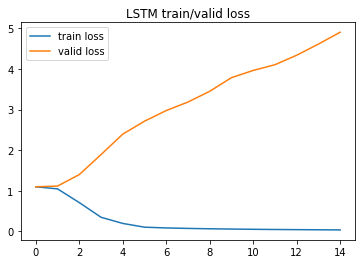

In [69]:
import matplotlib.pyplot as plt

plt.plot(trainloss)
plt.plot(validloss)
plt.legend(['train loss','valid loss'])
plt.title('LSTM train/valid loss')
plt.savefig('lstmloss.png',bbox = 'tight')

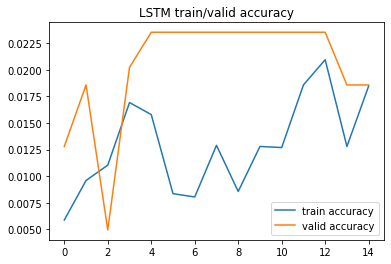

In [70]:
plt.plot(trainacc)
plt.plot(validacc)
plt.legend(['train accuracy','valid accuracy'])
plt.title('LSTM train/valid accuracy')
plt.savefig('lstmacc.png',bbox = 'tight')